In [1]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing package from pypi')
    !pip install pymagnet -q
else:
    print('Not running on CoLab.')

Not running on CoLab.


In [2]:
import numpy as np
import pymagnet as pm
%matplotlib inline
# %matplotlib notebook

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from numba import njit, guvectorize
PI = np.pi
MU0 = 4e-7*PI

A convenience function for plotting forces and torques:



In [3]:
def plot_force_result(offsets,f_total, spacing=None, compare=None, plot_type='force'):
    fig,ax = plt.subplots(figsize=(8,8))
    
    if plot_type.lower() == 'torque':
        labels = [ r"$\tau_x$", r"$\tau_y$", r"$\tau_z$"]
    else:
        labels = [ r"$F_x$", r"$F_y$", r"$F_z$"]
    
    plt.plot(offsets,f_total[:,0], label=labels[0])
    plt.plot(offsets,f_total[:,1], label=labels[1])
    plt.plot(offsets,f_total[:,2], label=labels[2])
    
    if spacing is not None and compare is not None:
        plt.scatter(spacing,compare[0])
        plt.scatter(spacing,compare[1])
        plt.scatter(spacing,compare[2])

    plt.legend(loc='best')
    if plot_type.lower() == 'torque':
        plt.ylabel(r'$\tau$ (mN.m)')
    else:
        plt.ylabel(r'$F$ (N)')
    plt.xlabel(r"$d$ (mm)")
    plt.grid(True)
    plt.show()

## Forces Between Cube Magnets

H. Allag and J.-P. Yonnet, 3-D Analytical Calculation of the Torque and Force Exerted Between Two Cuboidal Magnets, IEEE Trans. Magn. 45, 3969 (2009).

In [4]:
def gen_magnet_test(paper='Allag2009', **kwargs):
    pm.reset_magnets()
    alpha = 0
    beta = 0
    gamma = 0

    mask_magnet = kwargs.pop("mask_magnet", "nan")

    theta = kwargs.pop("theta", 0.0)
    phi = kwargs.pop("phi", 0.0)
    center = (0, 0, 0)
    
    if paper.lower() == 'allag2009':
        Jr = 1.0
        width = 10
        depth = 10
        height = 10
    else:
        Jr = 0.38
        width = 20
        depth = 12
        height = 6
    
    m1 = pm.magnets.Prism(
        width=width,
        depth=depth,
        height=height,
        Jr=Jr,
        center=center,
        theta=theta,
        phi=phi,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        mask_magnet=mask_magnet
    )

    offset = kwargs.pop("offset", 0.0)

    if paper.lower() == 'allag2009':
        width = 10
        depth = 10
        height = 10
        center = (0 + offset, 0, 10+10)
        
    else:
        width = 12
        depth = 20
        height = 6
        center = (-4 + offset, -4, 8)    

    m2 = pm.magnets.Prism(
        width=width,
        depth=depth,
        height=height,
        Jr=Jr,
        center=center,
        theta=theta,
        phi=phi,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        mask_magnet=mask_magnet
    )

    return m1, m2

In [5]:
def calc_forces_prism(paper='allag2009'):
    unit = 'mm'
    force_points = 101
    if paper.lower() == 'allag2009':
        offsets = np.linspace(-20,20,force_points)

    else:
        offsets = np.linspace(0,16,force_points)

    f_total = np.zeros((force_points,3))
    t_total = np.zeros((force_points,3))


    for i in range(force_points):
        m1, m2 = gen_magnet_test(paper=paper, offset = offsets[i])
        f_total[i], t_total[i] = m2.get_force_torque(num_samples = 20, unit=unit)

    if paper.lower() == 'allag2009':
        spacing = np.linspace(-20,20,41)
        compare = np.zeros((3,41))
        torque_compare = None
        compare[0] = np.array([0.285,0.351,0.436,0.479,0.548,0.638,0.718,0.802,0.884,0.951,1.009,1.05,1.057,1.032,0.981,0.887,0.758,0.618,0.424,0.219,-0.008,-0.2,-0.416,-0.595,-0.749,-0.877,-0.972,-1.033,-1.049,-1.028,-0.999,-0.938,-0.882,-0.797,-0.725,-0.646,-0.569,-0.495,-0.42,-0.367,-0.317])
        compare[1] = np.zeros(41)
        compare[2] = np.array([0.106,0.09,0.067,0.035,-0.023,-0.076,-0.158,-0.264,-0.384,-0.526,-0.692,-0.876,-1.081,-1.298,-1.497,-1.702,-1.887,-2.041,-2.142,-2.224,-2.253,-2.221,-2.145,-2.031,-1.877,-1.702,-1.5,-1.288,-1.084,-0.871,-0.694,-0.52,-0.375,-0.266,-0.163,-0.085,-0.022,0.024,0.06,0.084,0.102])
    else:
        spacing = np.linspace(0,16,9)
        compare = np.zeros((3,9))
        torque_compare = np.zeros((3,9))
        torque_compare[0]= np.array([-6.062,-6.3,-6.285,-6.315,-6.069,-5.069,-3.762,-2.438,-1.115])
        torque_compare[1]= np.array([-3.646,-2.069,-0.008,2.054,3.669,3.931,3.577,3.531,3.977])
        torque_compare[2]= np.array([-1.585,-0.654,0.023,0.654,1.608,2.438,2.7,2.777,2.731])

        compare[0] = np.array([0.583,0.244,0.002,-0.248,-0.587,-0.913,-1.067,-1.113,-1.052])
        compare[1] = np.array([0.583, 0.617, 0.637, 0.625, 0.587, 0.517, 0.429, 0.321, 0.213])
        compare[2] = np.array([-1.771,-1.86,-1.86,-1.856,-1.771,-1.467,-1.067,-0.64,-0.237])
        
    return offsets,f_total, t_total, spacing, compare, torque_compare


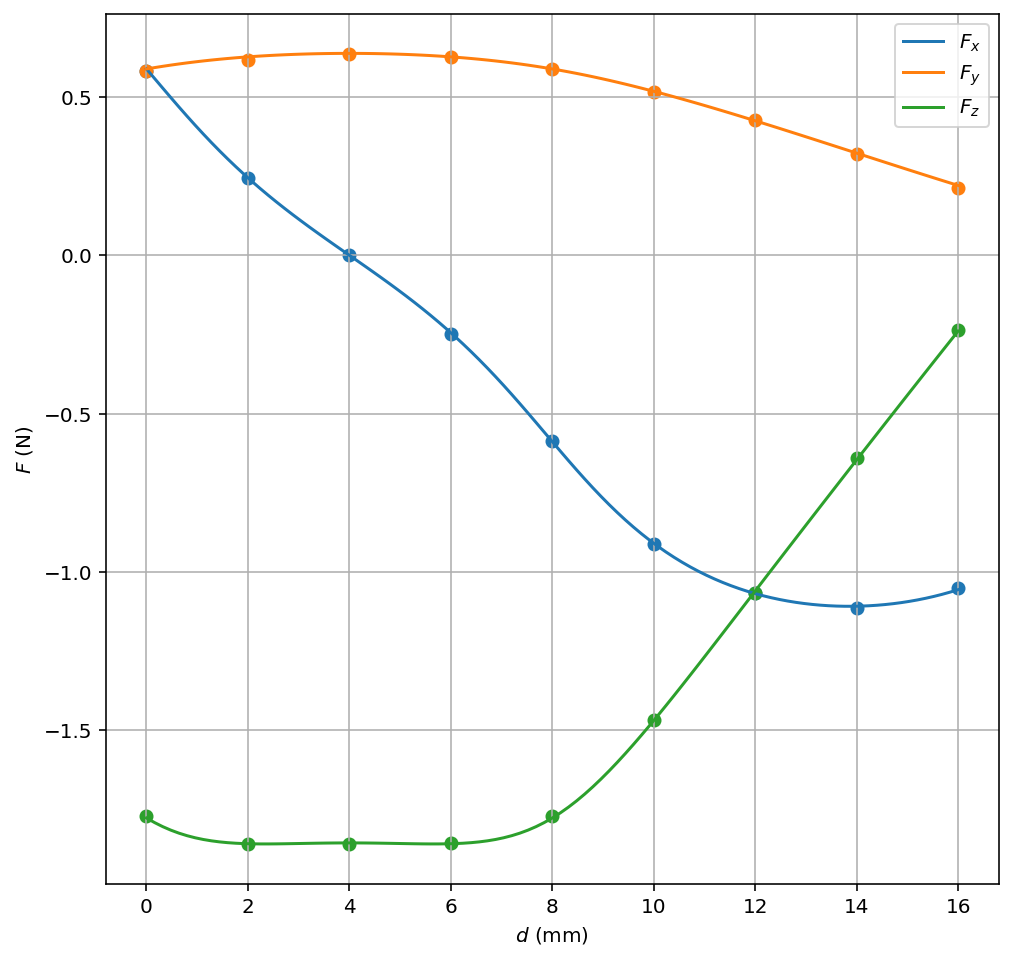

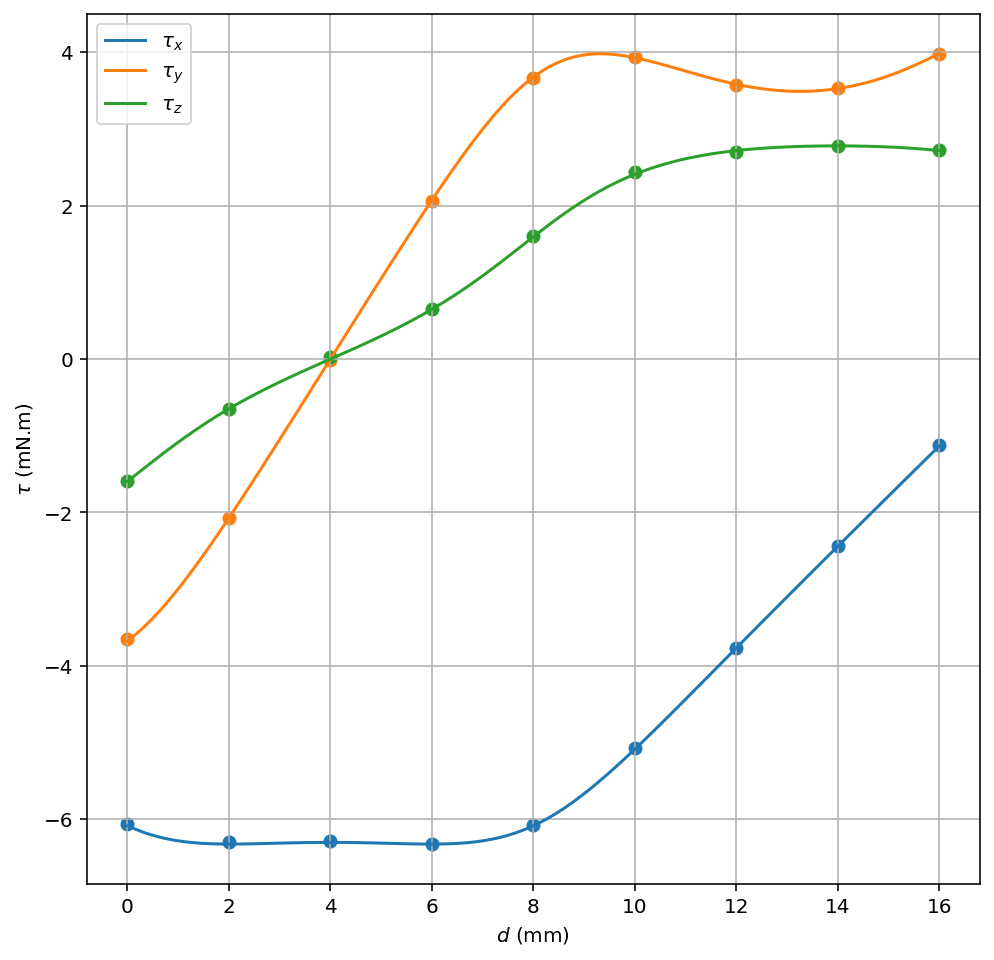

In [6]:
paper ='oconnell2020'

offsets,f_total, t_total, spacing, compare, torque_compare = calc_forces_prism(paper=paper)

plot_force_result(offsets,f_total, spacing, compare, plot_type='force')
plot_force_result(offsets,t_total*1e3, spacing, torque_compare, plot_type='torque')


3D Render:

![Slice Plot](img/oconnell2020.png)


In [ ]:
mask_magnet = False # mask values inside a magnet
show_magnets = True # draw magnet in plots
i=10
m1, m2 = gen_magnet_test(paper=paper,offset = offsets[i])
fig_slice, slice_cache, data_objects = pm.plots.slice_quickplot(cmax=0.2,
                                              num_levels=5,
                                              opacity=1.0,
                                              num_arrows=10,
                                              num_points=100,
                                              cone_opacity=0.9,
                                              magnet_opacity=1.0,
                                              mask_magnet = mask_magnet,
                                              show_magnets=show_magnets,
                                              max1 = 20,
                                              max2 = 20,
                                              slice_value= 0.0,
                                              unit = 'mm'
                               )

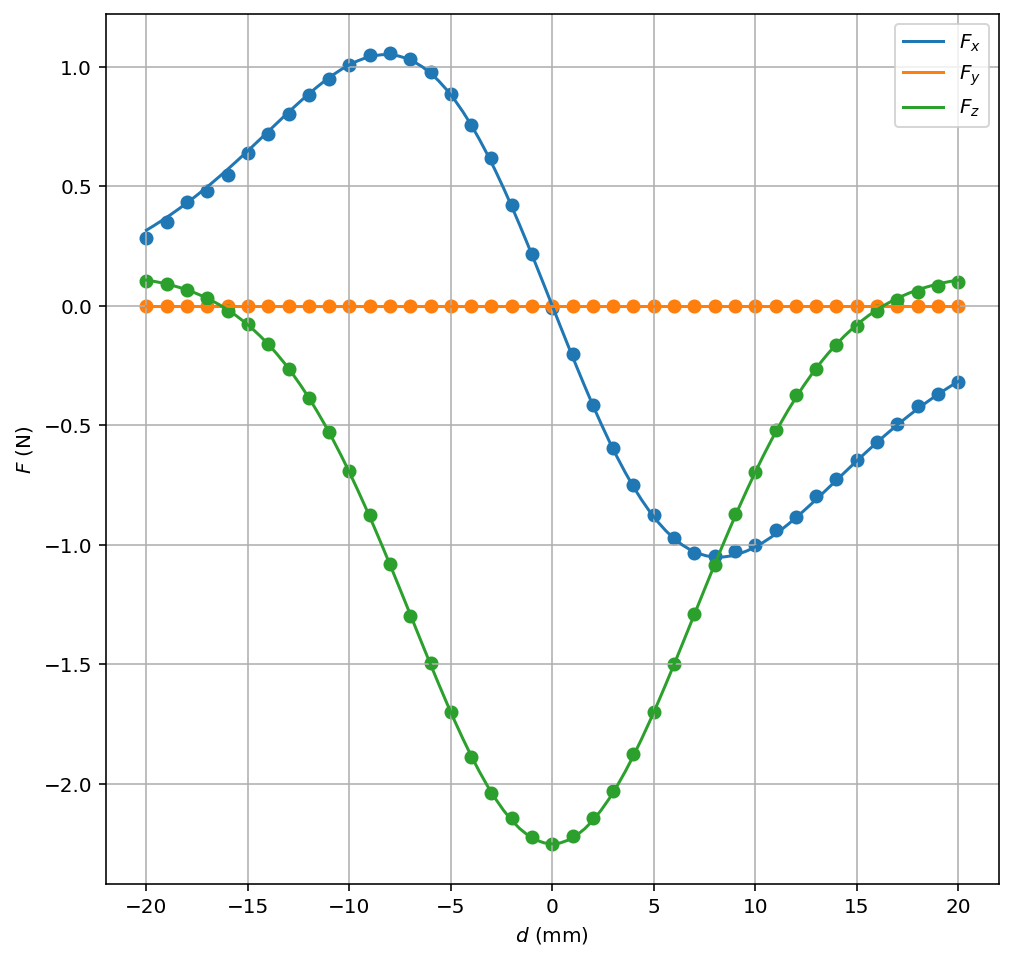

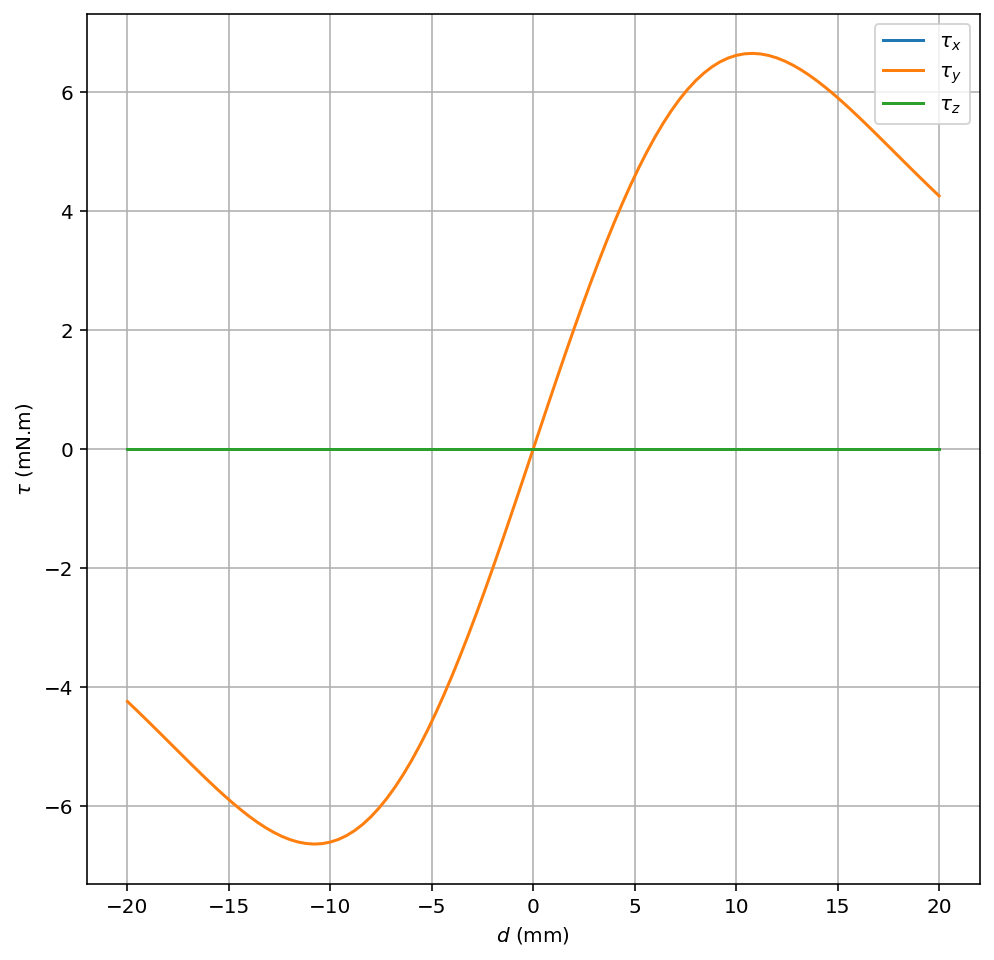

In [8]:
paper = 'allag2009'

offsets,f_total, t_total, spacing, compare, torque_compare = calc_forces_prism(paper=paper)

plot_force_result(offsets,f_total, spacing, compare, plot_type='force')
plot_force_result(offsets,t_total*1e3, None, None, plot_type='torque')


3D Render
![Slice Plot](img/allag2009.png)

In [ ]:
mask_magnet = False # mask values inside a magnet
show_magnets = True # draw magnet in plots
i=10
m1, m2 = gen_magnet_test(paper=paper,offset = offsets[i])
fig_slice, slice_cache, data_objects = pm.plots.slice_quickplot(cmax=0.3,
                                              num_levels=4,
                                              opacity=1.0,
                                              num_arrows=10,
                                              num_points=100,
                                              cone_opacity=0.9,
                                              magnet_opacity=1.0,
                                              mask_magnet = mask_magnet,
                                              show_magnets=show_magnets,
                                              max1 = 20,
                                              max2 = 20,
                                              slice_value= 0.0,
                                              unit = 'mm'
                               )

In [26]:
def gen_perp_field(alpha, beta, gamma, all_mag = True, **kwargs):
    pm.reset_magnets()

    width = 10
    depth = width*1
    height = width*1
    wall = 0.1
    z_offset = 0.0
    theta, phi = 0.0, 0.0
    Jr = 1.26

    
    mask_magnet = kwargs.pop('mask_magnet', 'nan')
    offset_x = kwargs.pop("offset_x", 0.0)
    offset_y = kwargs.pop("offset_y", 0.0)
    offset_z = kwargs.pop("offset_z", 0.0)

    
    center = (offset_x, offset_y, -height/2 - z_offset + offset_z)
    m0 = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = Jr, center=center,
                              theta = theta, phi = phi,
                              alpha = alpha,
                              beta = beta,
                              gamma = gamma,
                              mask_magnet=mask_magnet)
    
    
    if all_mag:
        center = (-width - wall, 0, -height/2 - z_offset)
        theta, phi = 0.0, 90.0
        m1 = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = Jr, center=center,
                                 theta = theta, phi = phi,
                                  alpha = alpha,
                                  beta = beta,
                                  gamma = gamma,
                                  mask_magnet=mask_magnet)

        center = (width + wall, 0, -height/2 - z_offset)
        theta, phi = 0.0, 90.0
        m2 = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = -Jr, center=center,
                                  theta = theta, phi = phi,
                                  alpha = alpha,
                                  beta = beta,
                                  gamma = gamma,
                                  mask_magnet=mask_magnet)

        center = (0, -depth - wall, -height/2 - z_offset)
        theta, phi = 90.0, 90.0
        m3 = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = Jr, center=center,
                                  theta = theta, phi = phi,
                                  alpha = alpha,
                                  beta = beta,
                                  gamma = gamma,
                                  mask_magnet=mask_magnet)

        center = (0, depth + wall, -height/2 -z_offset)
        theta, phi = 90.0, 90.0
        m4 = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = -Jr, center=center,
                                 theta = theta, phi = phi,
                                  alpha = alpha,
                                  beta = beta,
                                  gamma = gamma,
                                  mask_magnet=mask_magnet)
    else:
        m1, m2, m3, m4 = None, None, None, None
    
    return m0, m1, m2, m3, m4



3D Render
![Slice Plot](img/perp_field_slice.png)

In [ ]:
mask_magnet = False # mask values inside a magnet
show_magnets = True # draw magnet in plots


m0, m1, m2, m3, m4 = gen_perp_field(alpha=0.0, beta=0.0, gamma=0.0,
                                    all_mag=True, mask_magnet = mask_magnet,
                                   offset_x = 0,
                                   offset_y = 0,
                                   offset_z = 0)

fig_slice, slice_cache, data_objects = pm.plots.slice_quickplot(cmax=1.0,
                                              num_levels=11,
                                              opacity=1.0,
                                              num_arrows=10,
                                              num_points=40,
                                              cone_opacity=0.9,
                                              magnet_opacity=1.0,
                                              mask_magnet = mask_magnet,
                                              show_magnets=show_magnets,
                                              max1 = 20,
                                              max2 = 20,
                                              slice_value= 0.0,
                                              unit = 'mm'
                               )

In [28]:
m0, m1, m2, m3, m4 = gen_perp_field(alpha=0.0, beta=0.0, gamma=0.0,
                                    all_mag=True, mask_magnet = mask_magnet,
                                   offset_x = 0,
                                   offset_y = 0,
                                   offset_z = 0)

unit = 'mm'
force, torque = m1.get_force_torque(num_samples = 20, unit=unit)
force, torque


(array([-2.29197072e+01,  2.22638828e-16, -2.41442651e+01]),
 array([ 4.91892660e-18,  8.18459293e-02, -2.57426145e-19]))

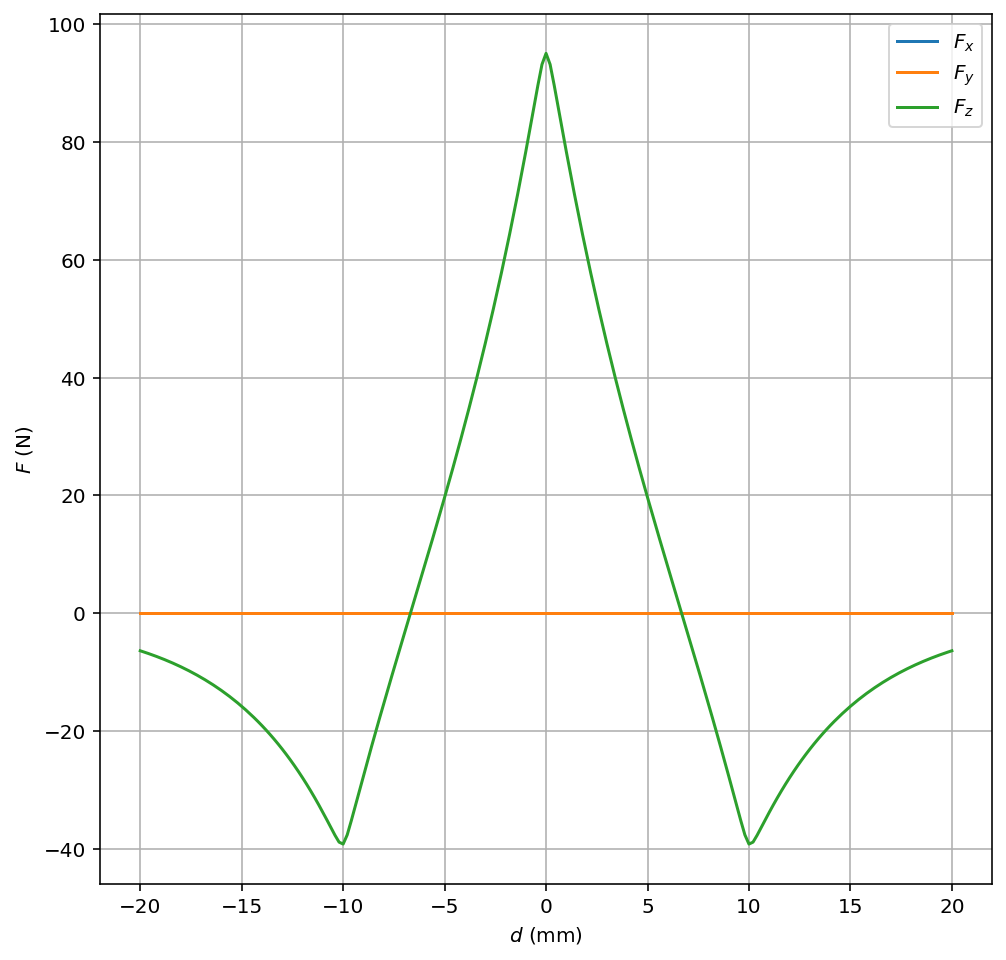

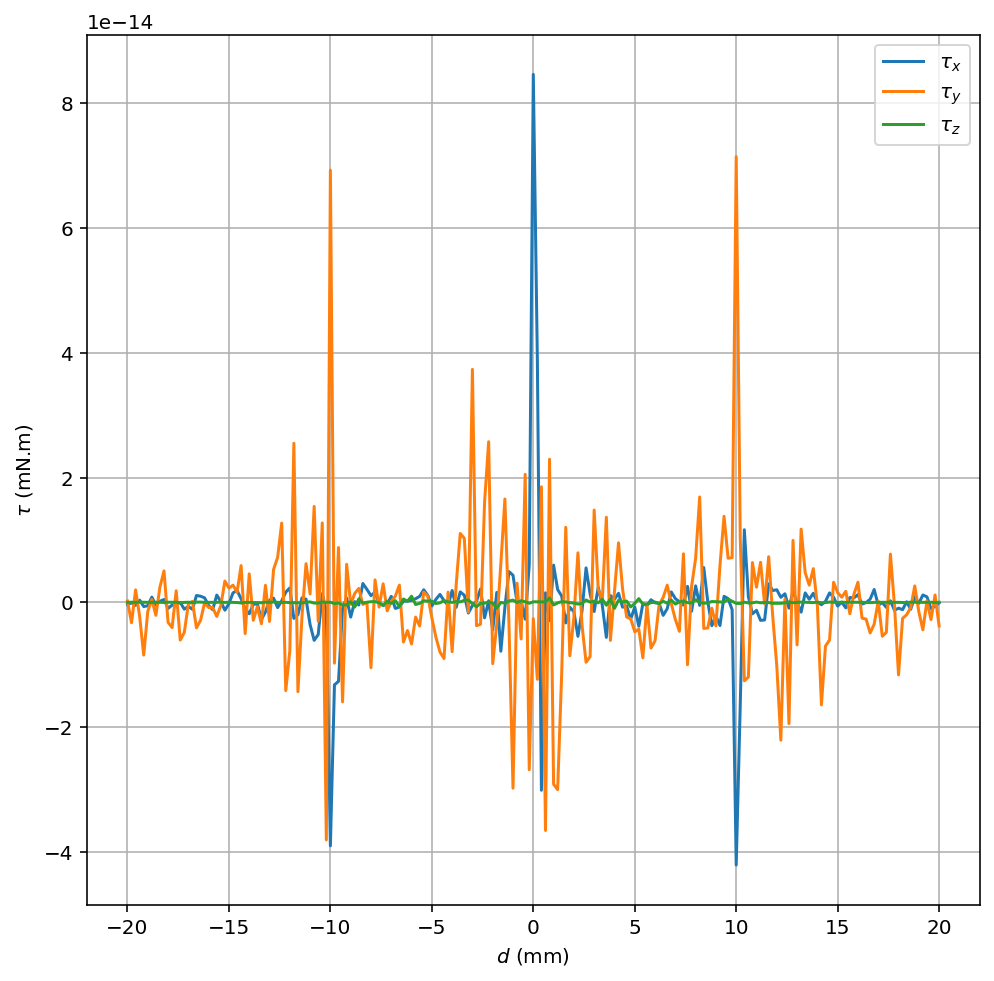

In [30]:
force_points = 201
offsets = np.linspace(-20,20,force_points)

f_total = np.zeros((force_points,3))
t_total = np.zeros((force_points,3))

unit = 'mm'

for i in range(force_points):
    m0, m1, m2, m3, m4 = gen_perp_field(alpha=0.0, beta=0.0, gamma=0.0, offset_z = offsets[i])
    f_total[i], t_total[i] = m0.get_force_torque(num_samples = 40, unit=unit)

plot_force_result(offsets,f_total, None, None, plot_type='force')
plot_force_result(offsets,t_total*1e3, None, None, plot_type='torque')

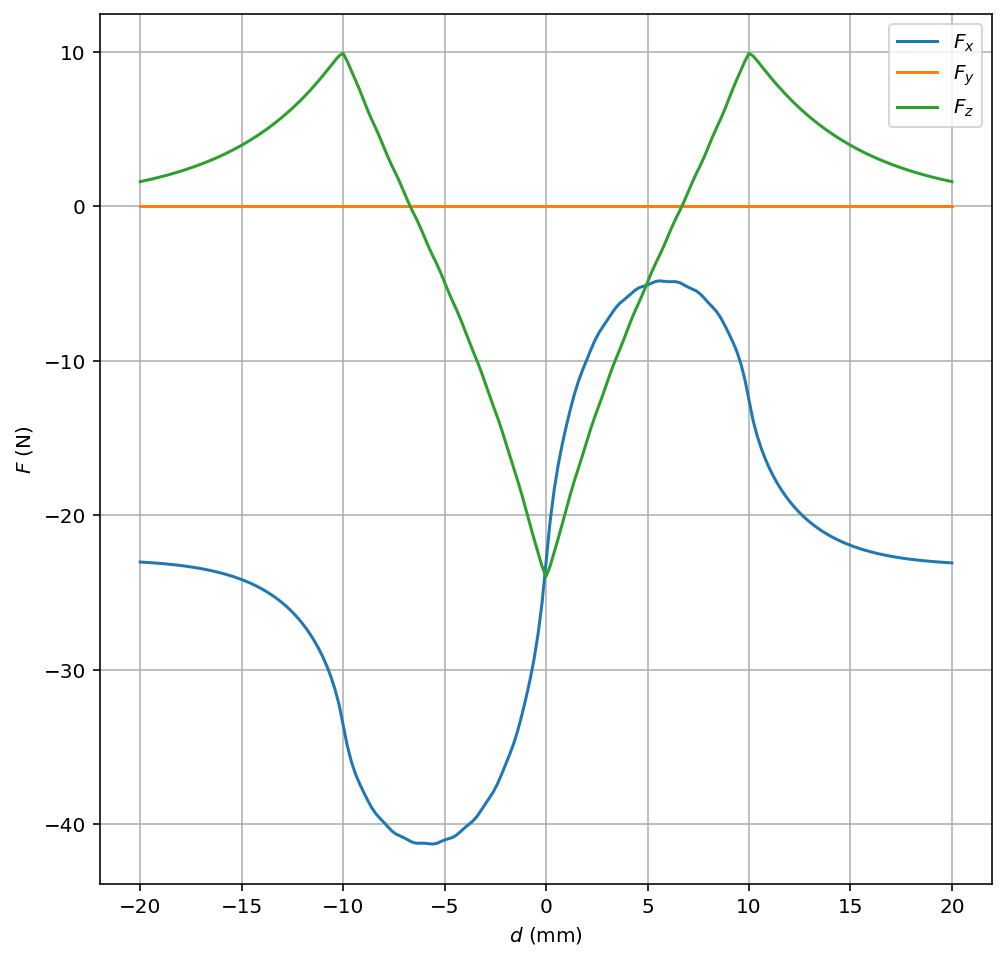

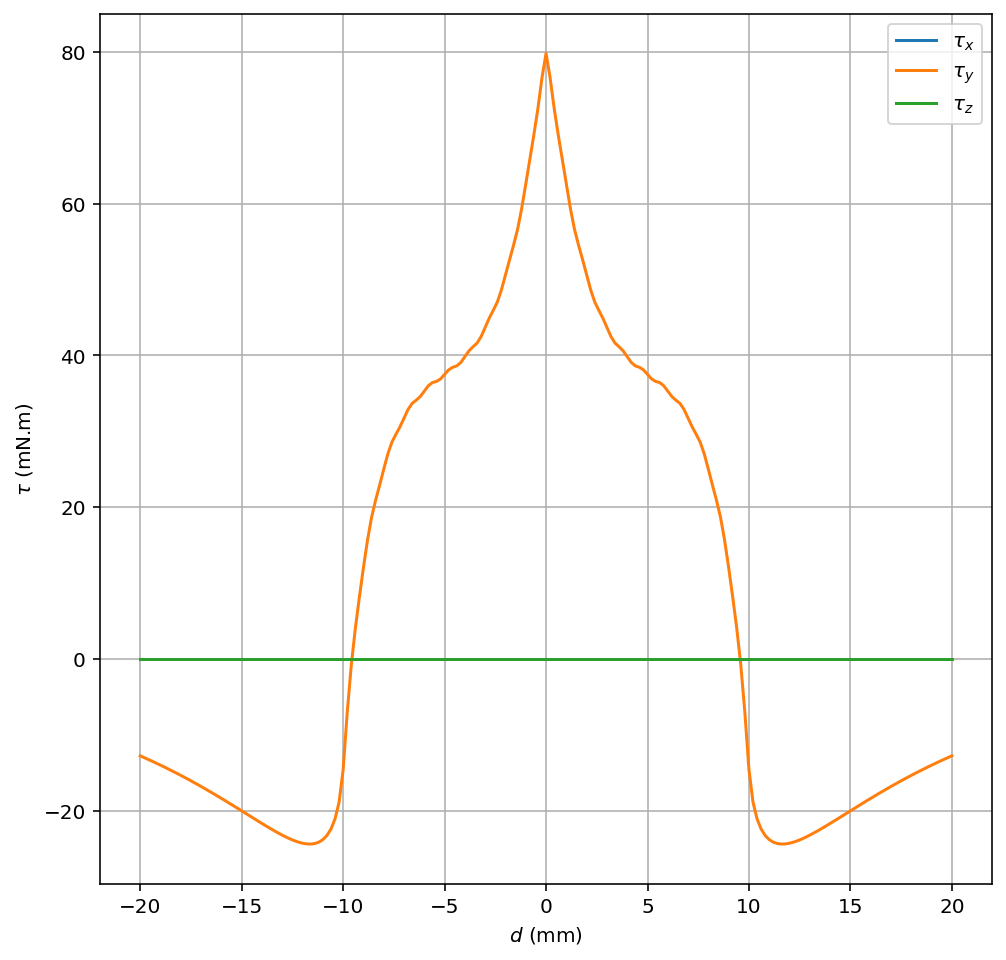

In [17]:
for i in range(force_points):
    m0, m1, m2, m3, m4 = gen_perp_field(alpha=0.0, beta=0.0, gamma=0.0, offset_z = offsets[i])
    f_total[i], t_total[i] = m1.get_force_torque(num_samples = 40, unit=unit)

plot_force_result(offsets,f_total, None, None, plot_type='force')
plot_force_result(offsets,t_total*1e3, None, None, plot_type='torque')

In [31]:
m0, m1, m2, m3, m4 = gen_perp_field(alpha=0.0, beta=0.0, gamma=0.0, offset_z =0)

force_assembly = np.zeros((len(pm.magnets.Magnet3D.instances),3))
torque_assembly = np.zeros_like(force_assembly)
i = 0
for magnet in [m0, m1, m2, m3, m4]:
    force_assembly[i], torque_assembly[i] = magnet.get_force_torque(num_samples = 40, unit=unit)
    i += 1
print("Order is: centre, left, right, down, up")
print("Forces (N):")
print(np.round(force_assembly,1))
print("Torques (mN.m):")

print(np.round(torque_assembly*1e3,1))

Order is: centre, left, right, down, up
Forces (N):
[[ -0.    0.   95.1]
 [-23.1   0.  -24. ]
 [ 23.1  -0.  -24. ]
 [  0.  -23.1 -24. ]
 [ -0.   23.1 -24. ]]
Torques (mN.m):
[[  0.    0.    0. ]
 [  0.   79.8  -0. ]
 [  0.  -79.8  -0. ]
 [-79.8  -0.   -0. ]
 [ 79.8  -0.   -0. ]]


In [32]:
def gen_pseudo_halbach(alpha, beta, gamma, **kwargs):
    pm.reset_magnets()

    width = 9
    depth = 50
    height = width
    wall = 0
    theta, phi = 0.0, 0.0
    Jr = 1.26

    
    mask_magnet = kwargs.pop('mask_magnet', 'nan')
    
    center = (0, 0, height + wall)
    _ = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = Jr, center=center,
                              theta = theta, phi = phi,
                              alpha = alpha,
                              beta = beta,
                              gamma = gamma,
                              mask_magnet=mask_magnet)
    center = (width + wall, 0, 0)
    _ = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = -Jr, center=center,
                              theta = theta, phi = phi,
                              alpha = alpha,
                              beta = beta,
                              gamma = gamma,
                              mask_magnet=mask_magnet)
    center = (0, 0, -height - wall)
    _ = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = Jr, center=center,
                              theta = theta, phi = phi,
                              alpha = alpha,
                              beta = beta,
                              gamma = gamma,
                              mask_magnet=mask_magnet)
    center = (-width - wall, 0, 0)
    _ = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = -Jr, center=center,
                              theta = theta, phi = phi,
                              alpha = alpha,
                              beta = beta,
                              gamma = gamma,
                              mask_magnet=mask_magnet)
    
    
    center = (height + wall, 0, height + wall)
    _ = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = Jr, center=center,
                              theta = theta, phi = 90,
                              alpha = alpha,
                              beta = beta,
                              gamma = gamma,
                              mask_magnet=mask_magnet)
    center = (height + wall, 0, -height - wall)
    _ = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = -Jr, center=center,
                              theta = theta, phi = 90,
                              alpha = alpha,
                              beta = beta,
                              gamma = gamma,
                              mask_magnet=mask_magnet)
    center = (-height - wall, 0, height + wall)
    _ = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = -Jr, center=center,
                              theta = theta, phi = 90,
                              alpha = alpha,
                              beta = beta,
                              gamma = gamma,
                              mask_magnet=mask_magnet)
    
    center = (-height - wall, 0, -height - wall)
    _ = pm.magnets.Prism(width = width, depth = depth, height = height, Jr = Jr, center=center,
                              theta = theta, phi = 90,
                              alpha = alpha,
                              beta = beta,
                              gamma = gamma,
                              mask_magnet=mask_magnet)




3D Slice
![3D Slice](img/pseudo_halbach_slice.png)

In [ ]:
mask_magnet = True # mask values inside a magnet
show_magnets = True # draw magnet in plots

gen_pseudo_halbach(alpha=0.0, beta=0.0, gamma=0.0, mask_magnet = mask_magnet)

fig_slice, slice_cache, data_objects = pm.plots.slice_quickplot(cmax=1.2,
                                              num_levels=13,
                                              opacity=1.0,
                                              num_arrows=10,
                                              num_points=200,
                                              cone_opacity=0.9,
                                              magnet_opacity=1.0,
                                              mask_magnet = mask_magnet,
                                              show_magnets=show_magnets,
                                              max1 = 30,
                                              max2 = 30,
                                              slice_value= 0.0,
                                              unit = 'mm'
                               )

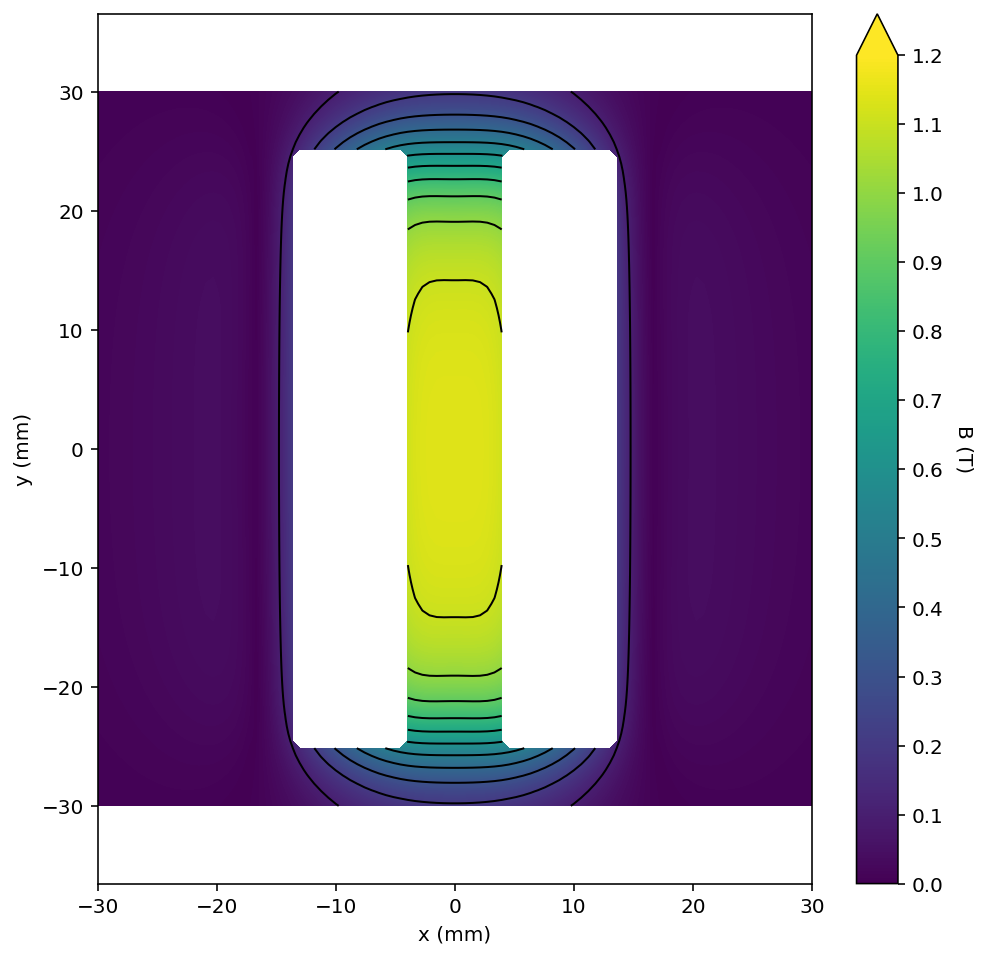

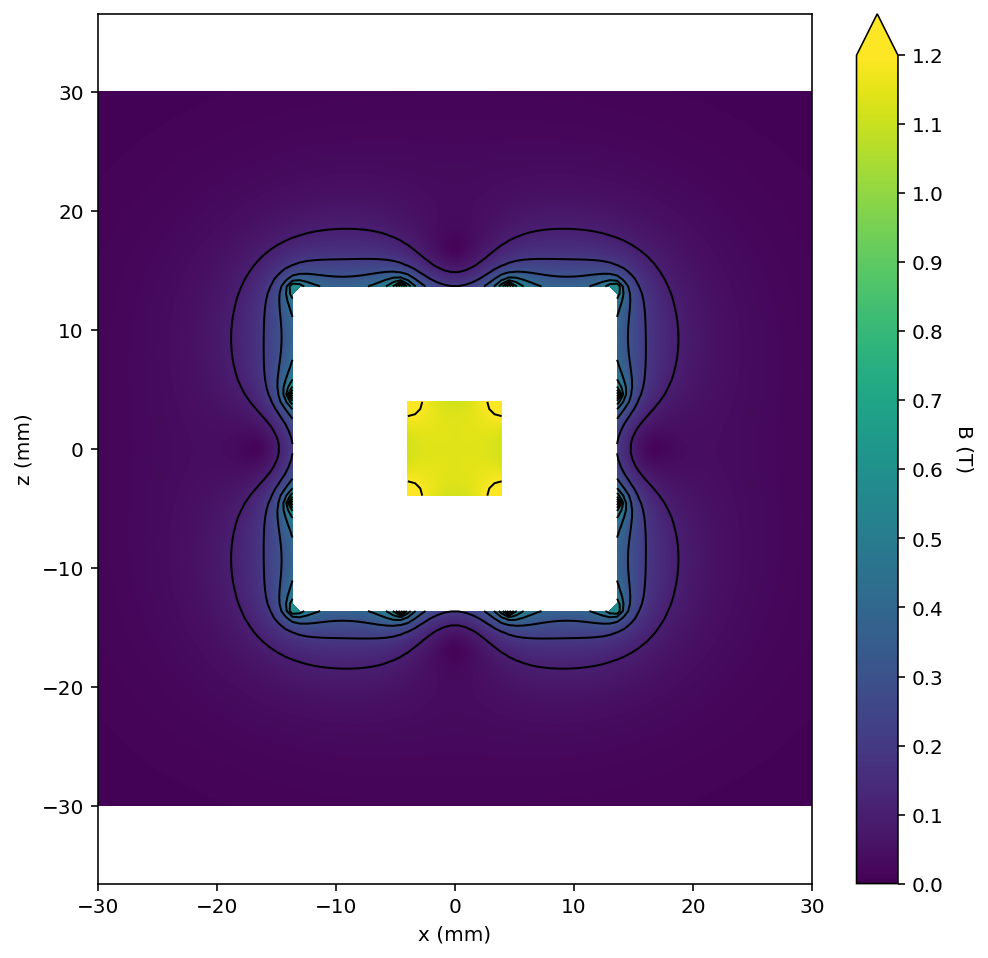

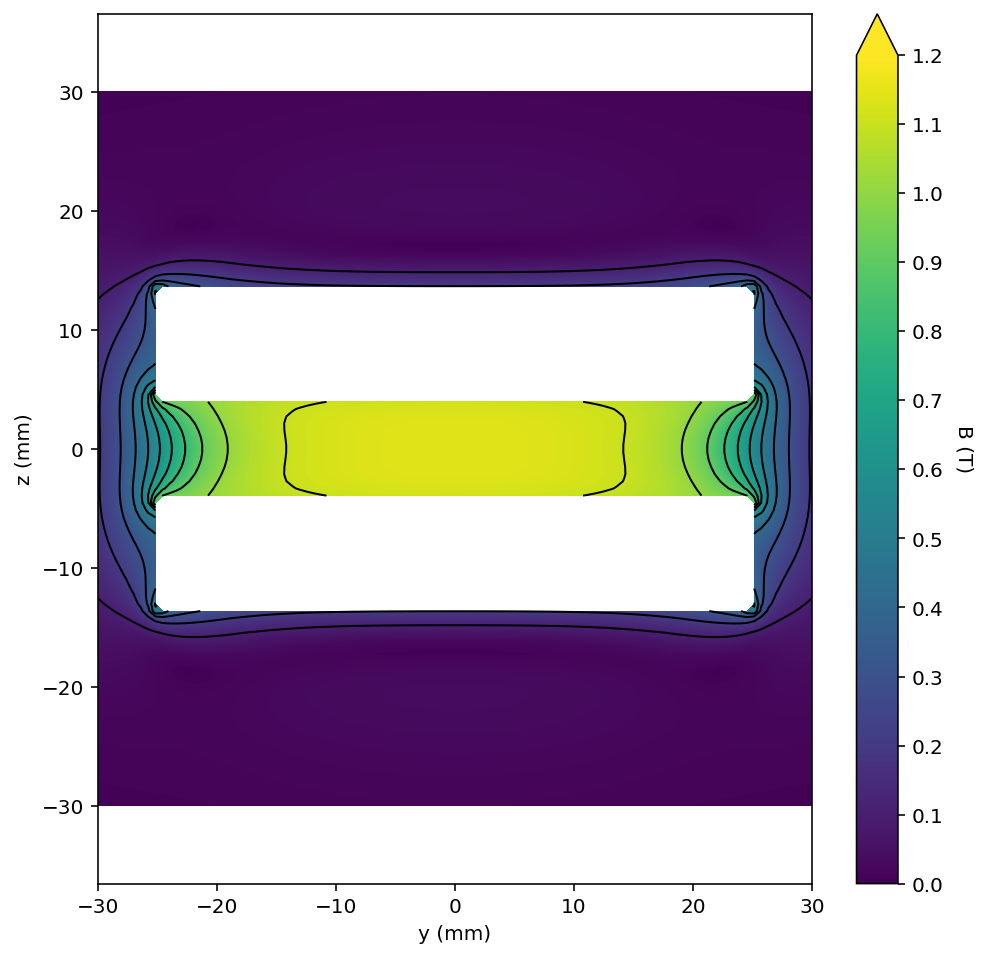

In [34]:
 for plane in slice_cache.keys():
    pm.plots.plot_3D_contour(slice_cache[plane]['points'], slice_cache[plane]['field'], plane,
                             cmin = 0,
                             cmax=1.2,
                             num_levels=13,
                             cmap='viridis',
                             
#                              num_arrows = 21,
#                              vector_color = 'k'
#                              plot_type="streamplot",
    #                          stream_color= 'vertical'
                            )


In [35]:
active_magnet = list(pm.magnets.Magnet3D.instances)[0]
active_magnet

for magnet in pm.magnets.Prism.instances:
    print(magnet)
    force, torque = magnet.get_force_torque(num_samples = 80, unit=unit)
    print(f"Force :{np.around(force,1)} (N), {np.around(force/9.80665,1)} (kg)")  
    print(f"Torque: {np.around(torque, 2)} (N.m)")
    print("==================\n")
#     print(f"Force :{force}, Torque: {torque}")

Prism
J: [-0.   -0.   -1.26] (T)
Size: [ 9 50  9]
Center [9 0 0] 
Orientation alpha,beta,gamma: [0. 0. 0.]

Force :[479.  -0.  -0.] (N), [48.8 -0.  -0. ] (kg)
Torque: [-0.  0.  0.] (N.m)

Prism
J: [-1.26 -0.   -0.  ] (T)
Size: [ 9 50  9]
Center [-9  0  9] 
Orientation alpha,beta,gamma: [0. 0. 0.]

Force :[114.9   0.  118.5] (N), [11.7  0.  12.1] (kg)
Torque: [ 0.   -1.18  0.  ] (N.m)

Prism
J: [0.   0.   1.26] (T)
Size: [ 9 50  9]
Center [0 0 9] 
Orientation alpha,beta,gamma: [0. 0. 0.]

Force :[  -0.     0.  -468.2] (N), [ -0.    0.  -47.7] (kg)
Torque: [ 0.  0. -0.] (N.m)

Prism
J: [0.   0.   1.26] (T)
Size: [ 9 50  9]
Center [ 0  0 -9] 
Orientation alpha,beta,gamma: [0. 0. 0.]

Force :[ -0.   -0.  468.2] (N), [-0.  -0.  47.7] (kg)
Torque: [-0. -0. -0.] (N.m)

Prism
J: [1.26 0.   0.  ] (T)
Size: [ 9 50  9]
Center [9 0 9] 
Orientation alpha,beta,gamma: [0. 0. 0.]

Force :[-114.9   -0.   118.5] (N), [-11.7  -0.   12.1] (kg)
Torque: [ 0.    1.18 -0.  ] (N.m)

Prism
J: [1.26 0.   0.  ] (

3D Volume
![3D Volume](img/pseudo_halbach_volume.png)

In [ ]:
fig_vol, vol_cache, data_objects = pm.plots.volume_quickplot(cmin=0.0,
                                    cmax=1.2,
                                    opacity=0.3,
                                    magnet_opacity=0.3,
                                    no_caps=True,
                                    num_levels=13,
                                    num_points=30,
                                    show_magnets = True,
                                    xmax = 4.5,
                                    xmin = 0,
                                    ymax = 30,
                                    ymin = -30,
                                    zmax = 4.5,
                                    zmin = -4.5,
                                    unit = 'mm',
                                    opacityscale = 'normal',
#                                     isomin=0.05,
#                                     isomax=0.5,
                                   )
